## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step1: Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import pickle

from IPython.display import HTML
from moviepy.editor import VideoFileClip

%matplotlib qt
#%matplotlib inline

In [2]:
def camera_calibration_coefficient(chessboardname):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
    images = glob.glob(chessboardname)

# Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

        # Draw and display the corners
           # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
          #  cv2.imshow('img',img)
          #  cv2.waitKey(500)

  #  cv2.destroyAllWindows()
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img.shape[1::-1],None,None)
    return ret,mtx,dist,rvecs,tvecs

In [3]:
ret,mtx,dist,rvecs,tvecs=camera_calibration_coefficient('camera_cal/calibration*.jpg')

In [4]:

dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist

pickle.dump(dist_pickle,open('output_images/calibration_pickle.pickle',"wb"))

## Step2: Apply a distortion correction to raw images.

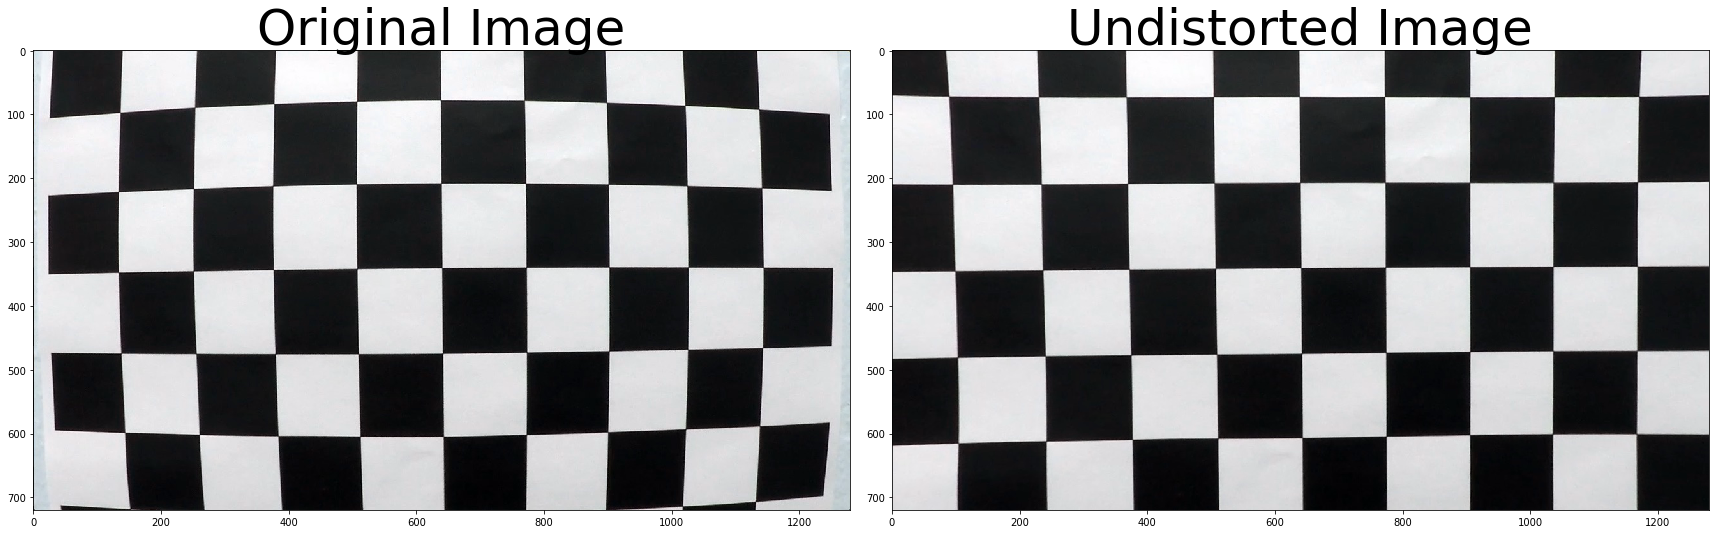

In [2]:
img_test1 = cv2.imread('camera_cal/calibration1.jpg')

dist_pickle = pickle.load( open( "output_images/calibration_pickle.pickle", "rb" ) )
# Correcting the distorted image
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
undistorted1 = cv2.undistort(img_test1,mtx,dist,None,mtx)

# display the result and save it to the specified directory.
f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(img_test1)
ax1.set_title('Original Image',fontsize=50)
ax2.set_title('Undistorted Image',fontsize=50)
ax2.imshow(undistorted1)
plt.savefig("output_images/undistort_output.png")

## Step3:Use color transforms, gradients, etc., to create a thresholded binary image.

In [19]:
# Define the gradient functions in the x and y directions
def abs_sobel_thresh(image,orient='x',sobel_kernel=3,thresh=(0,255)):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(gray)
    grad_binary[(scaled_sobel>thresh[0])&(scaled_sobel<thresh[1])] = 1
    return grad_binary

# Define the grandient functions 
def mag_thresh(image,sobel_kernel=3,mag_thresh=(0,255)):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    sobelxy = np.sqrt(sobelx*sobelx+sobely*sobely)
    scal_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    mag_binary = np.zeros_like(gray)
    mag_binary[(scal_sobel>mag_thresh[0])&(scal_sobel<mag_thresh[1])] = 1
    return mag_binary

# Define the grandient directions function
def dir_threshold(image,sobel_kernel=3,thresh=(0,np.pi/2)):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    dir_sobel = np.arctan2(abs_sobely,abs_sobelx)
    dir_binary = np.zeros_like(gray)
    dir_binary[(dir_sobel>thresh[0])&(dir_sobel<thresh[1])] = 1
    return dir_binary

# Define a color selection function in the S Channell of HLS color space.
def hls_s_select(image,thresh=(0,255)):
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    S = image_hls[:,:,2]
    hls_binary = np.zeros_like(S)
    hls_binary[(S>thresh[0])&(S<=thresh[1])] =1
    return hls_binary

def luv_l_slect(image,thresh =(0,255)):
    image_luv = cv2.cvtColor(image,cv2.COLOR_RGB2LUV)
    L = image_luv[:,:,0]
    luv_binary = np.zeros_like(L)
    luv_binary[(L>thresh[0])&(L<=thresh[1])] =1
    return luv_binary

def combined_image(image):
    ksize = 3
    gradx = abs_sobel_thresh(image,orient='x',sobel_kernel=ksize,thresh=(10,230))
    grady = abs_sobel_thresh(image,orient='y',sobel_kernel=ksize,thresh=(50,200))
    mag_binary = mag_thresh(image,sobel_kernel=ksize,mag_thresh=(30,150))
    dir_binary = dir_threshold(image,sobel_kernel=ksize,thresh=(0.7,1.3))
    hls_s_binary = hls_s_select(image,thresh = (100,255))
    luv_l_binary = luv_l_slect(image,thresh =(220,255))#
    

    combined = np.zeros_like(image[:,:,0])

    combined[(hls_s_binary==1) | (luv_l_binary==1)|((gradx==1) & (mag_binary==1) &(grady==1) & (dir_binary==1))]=1
    return combined

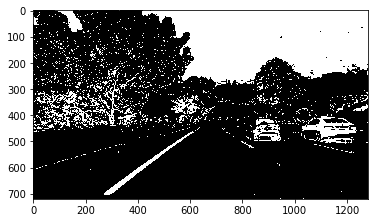

In [21]:
#image_test2 = plt.imread('test_images/straight_lines1.jpg')
image_test2 = plt.imread('test_images/test6.jpg')
undistorted = cv2.undistort(image_test2,mtx,dist,None,mtx)

mpimg.imsave("output_images/undistort_road.jpg",undistorted)
combined1 = combined_image(undistorted)



plt.imshow(combined1,cmap='gray')
mpimg.imsave("output_images/bonary_combo_example.jpg",combined1)

## Step4:Apply a perspective transform to rectify binary image ("birds-eye view").

In [5]:
# Open the image and convert to number matrix to choose pixel coordinate of 4 points manually.
#image1=np.array(Image.open('../output_images/bonary_combo_example.jpg')) 
#plt.figure("dog")
#plt.imshow(image1)
#plt.show()

In [6]:
def warp(img):
    #Difine calibration box in source(original) and destination (desired) coordinates
    img_size = (img.shape[1],img.shape[0])
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped,Minv

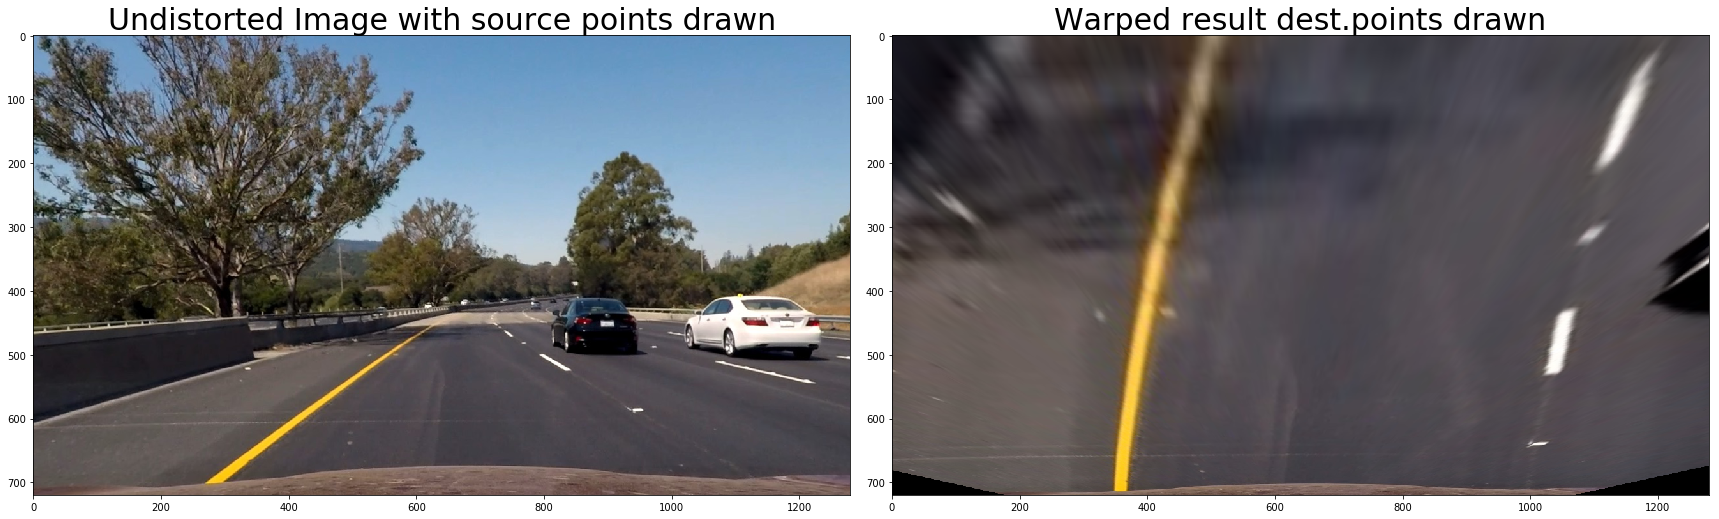

In [22]:
# 检查一下彩色效果
image_test2 = cv2.undistort(image_test2,mtx,dist,None,mtx)
warped_im,Minv = warp(image_test2)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(image_test2)
ax1.set_title('Undistorted Image with source points drawn',fontsize=30)
ax2.set_title('Warped result dest.points drawn',fontsize=30)
ax2.imshow(warped_im)
plt.savefig("output_images/warped_straight_lines.jpg")

## Step5:Detect lane pixels and fit to find the lane boundary.

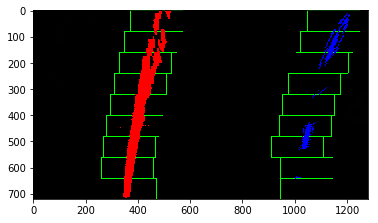

In [23]:

binary_warped,Minv = warp(combined1)

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
  

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]


    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)######################################################

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fit,right_fit,ploty#################################

out_img,left_fit,right_fit,ploty = fit_polynomial(binary_warped)

plt.imshow(out_img)
mpimg.imsave("output_images/color_fit_lines.jpg",out_img)

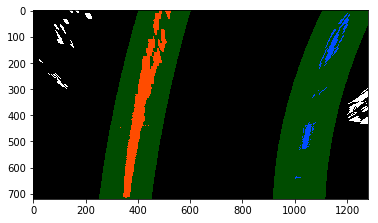

In [24]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1]*ploty +right_fit[2]
    
    return left_fitx, right_fitx, ploty,left_fit,right_fit

def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    #out_img,left_fit,right_fit,ploty = fit_polynomial(binary_warped)###########################################################
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty,left_fit,right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result,left_fit,right_fit,ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result,left_fit,right_fit,ploty= search_around_poly(binary_warped,left_fit,right_fit)

# View your output
plt.imshow(result)

## Step6:Determine the curvature of the lane and vehicle position with respect to center.

In [10]:
def calculate_curv_and_pos(binary_warped,left_fit, right_fit):
    # Define y-value where we want radius of curvature
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curvature = ((left_curverad + right_curverad) / 2)
    #print(curvature)
    lane_width = np.absolute(leftx[719] - rightx[719])
    lane_xm_per_pix = 3.7 / lane_width
    veh_pos = (((leftx[719] + rightx[719]) * lane_xm_per_pix) / 2.)
    cen_pos = ((binary_warped.shape[1] * lane_xm_per_pix) / 2.)
    distance_from_center = cen_pos - veh_pos
    return curvature,distance_from_center


In [11]:
curvature,distance_from_center = calculate_curv_and_pos(binary_warped,left_fit, right_fit)

print(curvature, 'm',distance_from_center,"m")

965.3993599560181 m -0.24943424317265084 m


## Step7:Warp the detected lane boundaries back onto the original image.

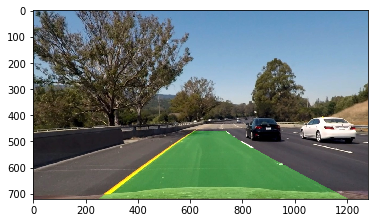

In [26]:
def draw_area(undist,binary_warped,Minv,left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
result = draw_area(image_test2,binary_warped,Minv,left_fit, right_fit)
plt.imshow(result)

## step8:Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

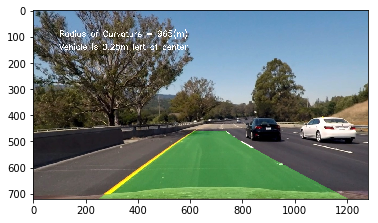

In [27]:
def draw_values(img,curvature, distance_from_center):
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    text_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    radius_text = "Radius of Curvature = %d(m)" % (round(curvature))
    cv2.putText(text_img, radius_text, (100, 100), font, 1, (255, 255, 255), 2)
    
    if distance_from_center > 0:
        pos_flag = 'right'
    else:
        pos_flag = 'left'
    center_text = "Vehicle is %.2fm %s of center" % (abs(distance_from_center), pos_flag)
    cv2.putText(text_img, center_text, (100, 150), font, 1, (255, 255, 255), 2)
    
    result = cv2.addWeighted(img, 1., text_img, 0.8, 0.)
    
    return result

result = draw_values(result,curvature, distance_from_center)
plt.imshow(result)
mpimg.imsave("output_images/example_output.jpg",result)

## Step8:Test on Videos

In [14]:
def process_image(image):
    dist_pickle = pickle.load( open( "output_images/calibration_pickle.pickle", "rb" ) )
    # Correcting the distorted image
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    undistorted = cv2.undistort(image,mtx,dist,None,mtx) # Apply a distortion correction to raw images
    combined1 = combined_image(undistorted) # Use color transforms, gradients, etc., to create a thresholded binary image
    binary_warped,Minv = warp(combined1)# Apply a perspective transform to rectify binary image ("birds-eye view")
    left_fit = []
    right_fit = []
    ploty = []
 
    line_detected = False
    
    if line_detected == False:
        out_img,left_fit,right_fit,ploty = fit_polynomial(binary_warped)
        if (len(left_fit) > 0 & len(right_fit) > 0) :
            line_detected == True
        else:
            line_detected == False
    else:
        result,left_fit,right_fit,ploty= search_around_poly(binary_warped,left_fit,right_fit)
        if (len(left_fit) > 0 & len(right_fit) > 0) :
            line_detected ==True
        else:
            line_detected == False
    
    curvature,distance_from_center = calculate_curv_and_pos(binary_warped,left_fit, right_fit)#:Determine the curvature of the lane and vehicle position with respect to center
    result = draw_values(image,curvature, distance_from_center) #Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position
    result1 = draw_area(result,binary_warped,Minv,left_fit, right_fit) #Warp the detected lane boundaries back onto the original image

    return result1

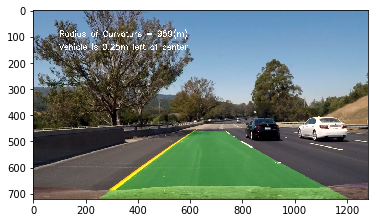

In [15]:
bbb = plt.imread('test_images/test6.jpg')
a= process_image(bbb)
plt.imshow(a)


In [17]:
white_output = 'output_images/project_video_test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_test.mp4
[MoviePy] Writing video output_images/project_video_test.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:22<00:00,  4.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_test.mp4 

Wall time: 4min 23s
